#Практическая работа №3

##__1__*. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.  



In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets as ds

from timeit import default_timer as timer

import warnings
warnings.filterwarnings('ignore')

In [36]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res


def logloss(w, X, y):
    y_pred = sigmoid(np.dot(w, X))
    y_pred[y_pred <= 0.0] = 1e-20
    y_pred[y_pred >= 1.0] = 1.0 - 1e-20

    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    grad = (1/X.shape[1] * np.dot(y_pred - y, X.T))
    return err, grad

##__2__. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [37]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [38]:
#def grad():
#  def grad_(X, y_err, W=0):
#    return (1/X.shape[1] * np.dot(y_err, X.T))
#  return grad_


In [39]:
def eval_model(X, y, iterations, err_call, alpha=1e-4, eps=None, errors=None):
    np.random.seed(42)
    w = np.random.randn(X.shape[0])
    err = np.inf
    for i in range(1, iterations+1):
      err_last = err
      err, grad = err_call(w, X, y)
      w -= alpha * grad
      if errors is not None:
        errors.append(err)
      if eps is not None:
        if np.abs(err-err_last) < eps:
          break
    return w, err, i

Text(0, 0.5, 'loss')

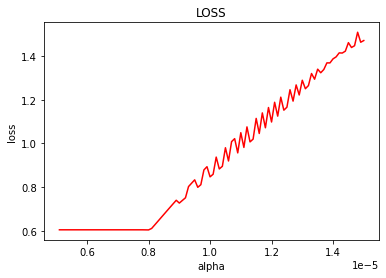

In [40]:
errors=[]
alphas=np.arange(15.0e-6, 5.0e-6, -1.0e-7)
for alpha_ in alphas:
    wi, erri, ii = eval_model(X, y, 5000, logloss, alpha=alpha_, eps=1.0e-7)
    errors.append(erri)

plt.plot(alphas, errors, color='r')
plt.title('LOSS')
plt.xlabel('alpha')
plt.ylabel('loss')

До скорости обучения 0.8e-5 потери минимальные, потом они начинают рости.

##__3.__Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [46]:
def calc_pred_proba(w, X):
  return sigmoid(np.dot(w, X))

In [47]:
    wi, erri, ii = eval_model(X, y, 5000, logloss, alpha=0.8e-5, eps=1.0e-7)
    calc_pred_proba(wi, X)

array([0.65927459, 0.54301919, 0.80794721, 0.60259352, 0.39951925,
       0.51660852, 0.67239102, 0.23351712, 0.68610092, 0.69577876])

##__4.__Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred)

In [76]:
def calc_pred(w, X, t = 0.5):
  y_pred = np.zeros(X.shape[1])
  y_pred[calc_pred_proba(w, X) >= t] = 1
  return y_pred

In [77]:
p=calc_pred(wi, X, 0.66)
print(p)

[0. 0. 1. 0. 0. 0. 1. 0. 1. 1.]


##__5.__Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [104]:
def matrix_error(y, y_pred):
  E=np.zeros((2,2), dtype=int)
  E[0,0]=np.sum((y==1) & (y_pred==1))
  E[0,1]=np.sum((y==0) & (y_pred==1))
  E[1,0]=np.sum((y==1) & (y_pred==0))
  E[1,1]=np.sum((y==0) & (y_pred==0))
  return E

def accuracy(E):
  return (E[0,0]+E[1,1])/np.sum(E)

def precision(E):
  return E[0,0]/(E[0,0]+E[0,1])

def recall(E):
  return E[0,0]/(E[0,0]+E[1,0])

def F_score(E, b=1):
  return (1+b**2)*(precision(E)*recall(E))/(b**2*precision(E)+recall(E))

In [105]:
Er=matrix_error(y, p)
print(f'accuracy = {accuracy(Er)}')
print(f'precision = {precision(Er)}')
print(f'recall = {recall(Er)}')
print(f'F1 = {F_score(Er)}')

accuracy = 0.9
precision = 1.0
recall = 0.8
F1 = 0.888888888888889


##__6.__Могла ли модель переобучиться? Почему?

Наверное нет, так как у прямой нет возможности повторить все значения.

##__7*.__Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [110]:
def logloss_L1(lambda_=1.0e-4):
  def logloss_L1_(w, X, y):
    y_pred = sigmoid(np.dot(w, X))
    y_pred[y_pred <= 0.0] = 1e-20
    y_pred[y_pred >= 1.0] = 1.0 - 1e-20

    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred)) +lambda_* np.mean(np.abs(w))
    grad = (1/X.shape[1] * np.dot(y_pred - y, X.T)) +lambda_* np.sign(w)
    return err, grad
  return logloss_L1_

def logloss_L2(lambda_=1.0e-4):
  def logloss_L2_(w, X, y):
    y_pred = sigmoid(np.dot(w, X))
    y_pred[y_pred <= 0.0] = 1e-20
    y_pred[y_pred >= 1.0] = 1.0 - 1e-20

    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred)) +lambda_/2* np.mean(w**2)
    grad = (1/X.shape[1] * np.dot(y_pred - y, X.T)) +lambda_* w
    return err, grad
  return logloss_L2_

In [145]:
wi, erri, ii = eval_model(X, y, 5000, logloss_L1(lambda_=1.7), alpha=0.8e-5, eps=1.0e-7)
p=calc_pred(wi, X, 0.66)
Er=matrix_error(y, p)
print(f'accuracy = {accuracy(Er)}')
print(f'precision = {precision(Er)}')
print(f'recall = {recall(Er)}')
print(f'F1 = {F_score(Er)}')

accuracy = 0.8
precision = 0.8
recall = 0.8
F1 = 0.8000000000000002


In [144]:
wi, erri, ii = eval_model(X, y, 5000, logloss_L2(lambda_=1.7), alpha=0.8e-5, eps=1.0e-7)
p=calc_pred(wi, X, 0.66)
Er=matrix_error(y, p)
print(f'accuracy = {accuracy(Er)}')
print(f'precision = {precision(Er)}')
print(f'recall = {recall(Er)}')
print(f'F1 = {F_score(Er)}')

accuracy = 0.8
precision = 0.8
recall = 0.8
F1 = 0.8000000000000002
